# Lab Six -  Convolutional Network Architectures
Amory Weinzierl, Fidelia Nawar, and Hayden Center

In this lab, you will select a prediction task to perform on your dataset, evaluate a deep learning architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

<b>Dataset Selection</b>

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

## Preparation (3 pts)

- [<b>1.5 points</b>] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a <b>detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate</b> for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [<b>1.5 points</b>] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). <b>Explain why your chosen method is appropriate or use more than one method as appropriate</b>. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)
print('Tensorflow:', tf.__version__)
print('Keras:',  keras.__version__)

Pandas: 1.2.1
Numpy: 1.19.2
Tensorflow: 2.3.0
Keras: 2.4.0


In [2]:
%%time

#source: https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
from PIL import Image

#source: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
from pathlib import Path

#directory name
paths = {
    "TRAIN": './Coronahack-Chest-XRay-Dataset/train/',
    "TEST":  './Coronahack-Chest-XRay-Dataset/test/'    
}
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')

h, w = 64, 64

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible

images = metadata[["X_ray_image_name", "Dataset_type"]]
X_data = []
y_data = metadata["Label"]
for idx, img in images.iterrows():
    name = img["X_ray_image_name"]
    path = img["Dataset_type"]
    img_arr = np.asarray(Image.open(paths[path] + name).convert('L').resize((h,w)))
    X_data.append(img_arr)

Wall time: 1min 8s


In [3]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
_X = np.expand_dims(np.array(X_data), axis=-1)/255 - 0.5
_y = le.fit_transform(np.array(y_data))

print(_X.shape, _y.shape)

(5910, 64, 64, 1) (5910,)


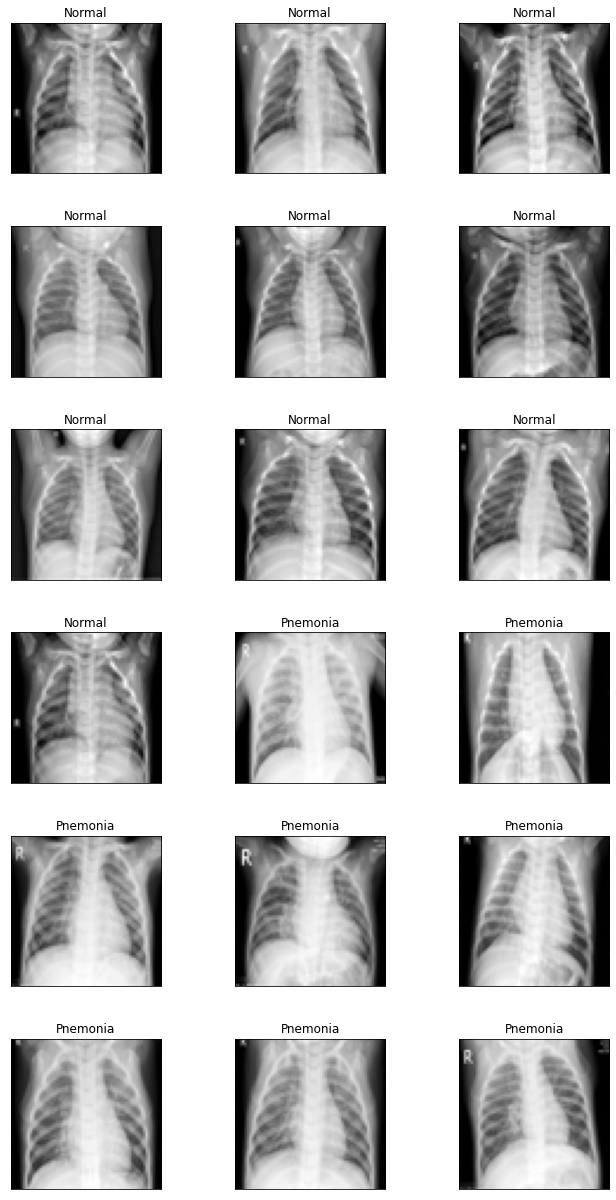

In [4]:
import matplotlib.pyplot as plt

display_imgs = np.concatenate((_X[0:9], _X[-9:]))
labels = np.concatenate((y_data[0:9], y_data[-9:]))
def plot_gallery(images, titles, n_row=3, n_col=3):
    plt.figure(figsize=(n_col * n_col, 6 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    #normal scans tended towards front
    for i in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    #pnemonia scans toward back so we pulled some from the back 
    #for demonstration purposes
    for j in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, n_row * n_col + j + 1)
        plt.imshow(images[-1*j], cmap=plt.cm.gray)
        plt.title(titles[-1*j], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(display_imgs, labels)

#### Evaluation Metric

The primary evaluation metric we are using for our model is the f-score, and therefore we are also measuring recall and precision. Recall measures the percentage of positive cases that were identified correctly, precision measures the percentage of positive predictions that were correct, and f-score is a formula which combines those two metrics into one score.

These metrics emphasize correct positive identifications, which is applicable to evaluate our solution because we want to minimize the amount of undetected pneumonia lungs, though recall is the more important metric, as it can be used to minimize the false negative rate. Having a low false negative rate is important in this situation because a diagnosis of a "Normal" lung condition when it is in fact penumonia is detrimental and possibly fatal to the patient. On the same token, it's necessary that healthy lungs are not misclassified as pneumonia because that would create unnecessary issues for a healthy patient. Because of this, we chose to use f-score, as well as recall and precision for auxiliary metrics, to evaluate our CNN solution.

#### Dividing Data

We are using stratified 10-fold cross validation in order to split up the data into training and test sets. We chose to use this method because almost 3/4 of our the lungs in our dataset are labeled as having pneumonia, whereas only 1/4 is labeled as healthy. Thus, if we did a random split/shuffle, there may be disproportionate amounts of pneumonia classification in the training variables, which would make the classification for the testing data less accurate. With 
stratified 10-fold cross validation, we can make a more effective model and also help with generalizing. It allows us to select training and testing sets while also decreasing overall variance because of the 10 folds, which will fit each CNN on each fold. This would be a realistic measuring of a real-world application of the algorithm because with smaller test sets, there is higher variance. Stratified cross validation reduces this variance by averaging over k different partitions, so the performance estimate is less sensitive to the partitioning of the data. We also chose 10 folds because this value has been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.

Additionally, we will be using an 80/20 split, where the 80% test set will be used for cross validation, and then used to train our final models for statistical comparisons of performance on the 20% split, as cross validation does not render a final trained model, and is only useful for comparing our evaluation metrics when exposed to data it hasn't seen before.

In [5]:
from sklearn.model_selection import train_test_split

X, X_final, y, y_final = train_test_split(_X, _y, test_size=0.2, stratify=_y)

## Modeling (6 pts)

- [<b>1.5 points</b>]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [<b>2 points</b>] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [<b>1.5 points</b>] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [<b>1 points</b>] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

We are using Keras's built in ImageDataGenerator for our data expansion. In reshaping all of our images to 128x128, many of the images were already stretched and squashed in different directions, and so expanding our dataset to stretch and squash them more randomly will hopefully remove any hidden biases that the different image sizes may have created. Additionally, since all of the xrays are more or less similarly oriented, we can add a slight rotational adjustment. However, since the images should all be uniquely oriented horizontally (because the heart is always located to one side of the body) and vertically (all of the images have the patients neck and shoulders on the top side of the image), it would not be useful to flip the images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

In [7]:
from tensorflow.keras.layers       import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers       import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models       import Model, Sequential
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.utils        import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

loss = 'binary_crossentropy'
optimizer = 'rmsprop'
metrics = [keras.metrics.Precision(), keras.metrics.Recall()]
batch_size = 128
epochs = 5
verbose = 1
n_splits = 2
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
models = {}

In [8]:
def plot_histories(model):
    histories = model['histories']
    title     = model['title']
    
    fig, subplots = plt.subplots(2,3,figsize=(15,8))
    fold_names = ["Fold " + str(fold) for fold in range(n_splits)]
    for fold_no, history in enumerate(histories):
        keys = list(history.history.keys())
        
        subplots[0,0].plot(history.history[keys[0]], label=fold_no)
        subplots[0,0].set_title('Binary Crossentropy')

        subplots[0,1].plot(history.history[keys[1]], label=fold_no)
        subplots[0,1].set_title('Precision')
        subplots[0,1].set_ylim(0.4, 1.1)

        subplots[0,2].plot(history.history[keys[2]], label=fold_no)
        subplots[0,2].set_title('Recall')
        subplots[0,2].set_ylim(0.4, 1.1)
        
        subplots[1,0].plot(history.history[keys[3]], label=fold_no)
        subplots[1,0].set_title('Validation Binary Crossentropy')

        subplots[1,1].plot(history.history[keys[4]], label=fold_no)
        subplots[1,1].set_title('Validation Precision')
        subplots[1,1].set_ylim(0.4, 1.1)

        subplots[1,2].plot(history.history[keys[5]], label=fold_no)
        subplots[1,2].set_title('Validation Recall')
        subplots[1,2].set_ylim(0.4, 1.1)
    handles, labels = subplots[1,2].get_legend_handles_labels()
    fig.suptitle(title, fontsize=16)
    fig.legend(handles, labels, title="Fold #")

### Model 1 - Basic Architecture

In [9]:
def build_basic_model(kernel_size, metrics):
    reg = l2(0.00001)
    cnn = Sequential()

    cnn.add(Conv2D(filters=32,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=64,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu',
                kernel_regularizer=reg))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid',
                kernel_regularizer=reg))

    cnn.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
    
    return cnn

### Model 2 - Network in Network Architecture

In [10]:
def build_nin_model(kernel_size, metrics):
    reg = l2(0.00001)
    cnn = Sequential()

    cnn.add(Conv2D(filters=32,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(filters=64,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(filters=64,
                kernel_size=kernel_size,
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=1,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))

    cnn.add(Flatten())
    cnn.add(Dense(1, activation='sigmoid',
                kernel_regularizer=reg))

    cnn.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
    
    return cnn

### Comparison Model - MLP

In [11]:
def build_mlp_model(kernel_size, metrics):
    reg = l2(0.00001)
    
    mlp = Sequential()
    mlp.add( Dropout(0.25))
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=images.shape[1], units=100, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dropout(0.5))
    mlp.add( Dense(units=50, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dense(units=50, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dense(1) )
    mlp.add( Activation('sigmoid') )

    mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision', 'Recall'])
    
    return mlp

### Evaluating Models

In [12]:
build = {
    'Basic': build_basic_model,
    'NiN':   build_nin_model,
    'MLP':   build_mlp_model
}

def create_model(arch, kernel_size):
    if kernel_size > 0:
        title = arch + ' (Kernel Size: ' + str(kernel_size) + ')'
    else:
        title = arch
    
    print(title)
    print('')
    print("Cross Validation")
    print('')
    
    fold_no = 0
    histories = []
    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = build[arch](kernel_size, metrics)

        print('Fold',fold_no)
        print('')
        
        history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=int(len(X_train)/batch_size),
                            epochs=epochs, verbose=verbose,
                            validation_data=(X_test, y_test))

        print('-' * 110)
        
        scores.append(np.array(list(history.history.values()))[:,-1])
        histories.append(history)
        
        fold_no += 1

    scores = np.array(scores)
    print("Cross Validation Average Performance")
    print(f"Precision:  {round(np.mean(scores[:,4]), 5)}")
    print(f"Recall:     {round(np.mean(scores[:,5]), 5)}")
    print('-' * 110)
    print('Evaluation Model')
    print('')
    
    model = build[arch](kernel_size, metrics)
    model.fit(datagen.flow(X, y, batch_size=batch_size), 
                         steps_per_epoch=int(len(X)/batch_size),
                         epochs=epochs, verbose=verbose,
                         validation_data=(X_final, y_final))
    prob = model.predict(X_final)
    results = np.round(prob)

    return {'title':       title,
            'arch':        arch,
            'kernel_size': kernel_size,
            'histories':   histories,
            'scores':      scores,
            'model':       model,
            'probs':       prob,
            'results':     results,
           }

#### Basic Model 1

In [13]:
%%time

models['b1'] = create_model('Basic', 3)

Basic (Kernel Size: 3)

Cross Validation

Fold 0

Epoch 1/5
18/18 [==============================] - 23s 1s/step - loss: 0.7253 - precision: 0.7404 - recall: 0.9323 - val_loss: 0.4728 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/5
18/18 [==============================] - 23s 1s/step - loss: 0.4355 - precision: 0.8241 - recall: 0.9587 - val_loss: 0.2902 - val_precision: 0.9241 - val_recall: 0.9556
Epoch 3/5
18/18 [==============================] - 22s 1s/step - loss: 0.3277 - precision: 0.8969 - recall: 0.9335 - val_loss: 0.2219 - val_precision: 0.9508 - val_recall: 0.9365
Epoch 4/5
18/18 [==============================] - 23s 1s/step - loss: 0.3022 - precision: 0.9178 - recall: 0.9379 - val_loss: 0.2958 - val_precision: 0.8605 - val_recall: 0.9931
Epoch 5/5
18/18 [==============================] - 22s 1s/step - loss: 0.2815 - precision: 0.9218 - recall: 0.9420 - val_loss: 0.2291 - val_precision: 0.9691 - val_recall: 0.9059
-------------------------------------------------------

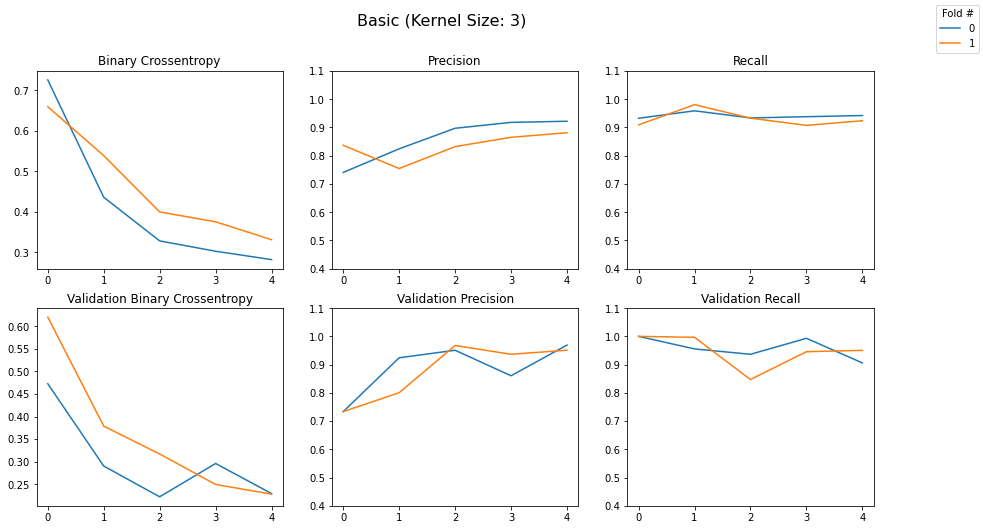

In [14]:
plot_histories(models['b1'])

#### Basic Model 2

In [15]:
%%time

models['b2'] = create_model('Basic', 5)

Basic (Kernel Size: 5)

Cross Validation

Fold 0

Epoch 1/5
18/18 [==============================] - 49s 3s/step - loss: 0.7167 - precision: 0.8040 - recall: 0.9198 - val_loss: 0.5645 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 2/5
18/18 [==============================] - 49s 3s/step - loss: 0.5916 - precision: 0.7483 - recall: 0.8738 - val_loss: 0.4837 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 3/5
18/18 [==============================] - 50s 3s/step - loss: 0.4704 - precision: 0.8240 - recall: 0.9378 - val_loss: 0.2687 - val_precision: 0.8940 - val_recall: 0.9786
Epoch 4/5
18/18 [==============================] - 49s 3s/step - loss: 0.4052 - precision: 0.8894 - recall: 0.9046 - val_loss: 0.2807 - val_precision: 0.9563 - val_recall: 0.9221
Epoch 5/5
18/18 [==============================] - 49s 3s/step - loss: 0.2536 - precision: 0.9237 - recall: 0.9374 - val_loss: 0.4157 - val_precision: 0.9873 - val_recall: 0.7184
-------------------------------------------------------

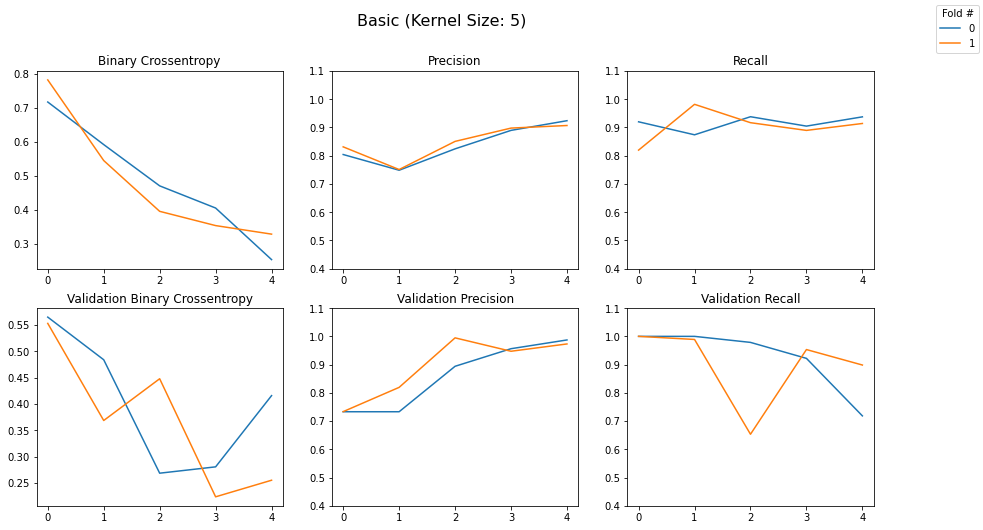

In [16]:
plot_histories(models['b2'])

#### NiN Model 1

In [17]:
%%time

models['n1'] = create_model('NiN', 3)

NiN (Kernel Size: 3)

Cross Validation

Fold 0

Epoch 1/5
18/18 [==============================] - 16s 910ms/step - loss: 0.6927 - precision: 0.7975 - recall: 0.9541 - val_loss: 0.6896 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 2/5
18/18 [==============================] - 16s 889ms/step - loss: 0.6872 - precision: 0.7326 - recall: 1.0000 - val_loss: 0.6848 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 3/5
18/18 [==============================] - 16s 876ms/step - loss: 0.6825 - precision: 0.7375 - recall: 1.0000 - val_loss: 0.6805 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 4/5
18/18 [==============================] - 16s 882ms/step - loss: 0.6788 - precision: 0.7303 - recall: 1.0000 - val_loss: 0.6764 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 5/5
18/18 [==============================] - 16s 886ms/step - loss: 0.6745 - precision: 0.7339 - recall: 1.0000 - val_loss: 0.6724 - val_precision: 0.7331 - val_recall: 1.0000
------------------------------------------

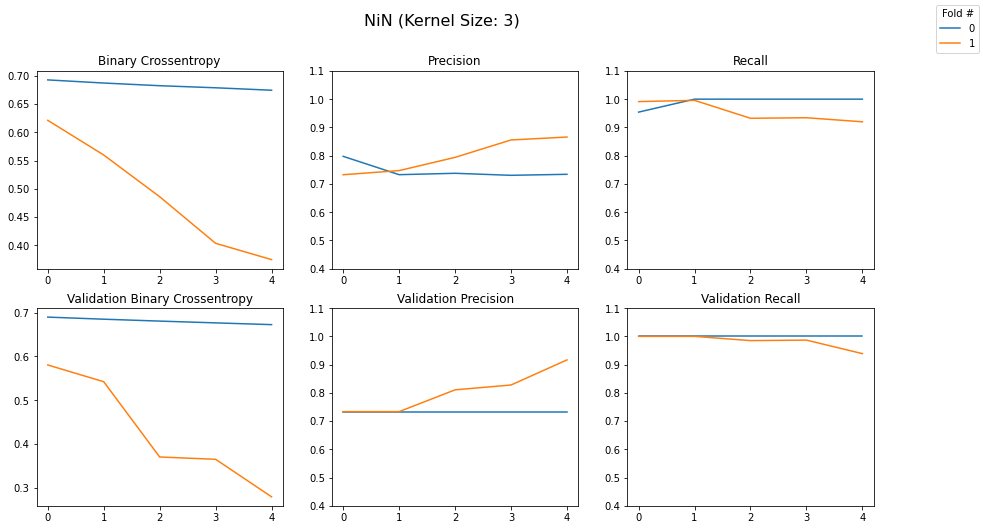

In [18]:
plot_histories(models['n1'])

#### NiN Model 2

In [19]:
%%time

models['n2'] = create_model('NiN', 5)

NiN (Kernel Size: 5)

Cross Validation

Fold 0

Epoch 1/5
18/18 [==============================] - 26s 1s/step - loss: 0.6166 - precision: 0.7343 - recall: 0.9813 - val_loss: 0.5600 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 2/5
18/18 [==============================] - 25s 1s/step - loss: 0.5156 - precision: 0.7825 - recall: 0.9519 - val_loss: 0.3330 - val_precision: 0.9160 - val_recall: 0.9371
Epoch 3/5
18/18 [==============================] - 25s 1s/step - loss: 0.3918 - precision: 0.8682 - recall: 0.9079 - val_loss: 0.2737 - val_precision: 0.9323 - val_recall: 0.9452
Epoch 4/5
18/18 [==============================] - 25s 1s/step - loss: 0.3145 - precision: 0.8891 - recall: 0.9298 - val_loss: 0.2471 - val_precision: 0.9587 - val_recall: 0.9100
Epoch 5/5
18/18 [==============================] - 24s 1s/step - loss: 0.3216 - precision: 0.8963 - recall: 0.9270 - val_loss: 0.2365 - val_precision: 0.9322 - val_recall: 0.9677
---------------------------------------------------------

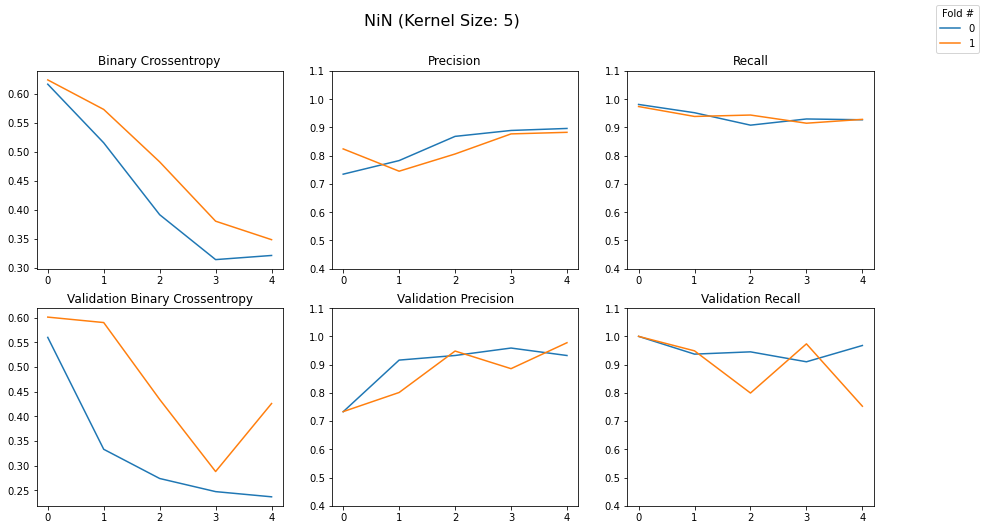

In [20]:
plot_histories(models['n2'])

#### MLP Model

In [21]:
%%time

mlp = create_model('MLP', 0)

MLP

Cross Validation

Fold 0

Epoch 1/5
18/18 [==============================] - 2s 91ms/step - loss: 0.4207 - precision: 0.8194 - recall: 0.9525 - val_loss: 0.2667 - val_precision: 0.9704 - val_recall: 0.8713- loss: 0.4580 - precision: 0.7959 - re
Epoch 2/5
18/18 [==============================] - 1s 77ms/step - loss: 0.2747 - precision: 0.9146 - recall: 0.9406 - val_loss: 0.2003 - val_precision: 0.9553 - val_recall: 0.9377
Epoch 3/5
18/18 [==============================] - 1s 74ms/step - loss: 0.2578 - precision: 0.9232 - recall: 0.9439 - val_loss: 0.1969 - val_precision: 0.9608 - val_recall: 0.9336
Epoch 4/5
18/18 [==============================] - ETA: 0s - loss: 0.2608 - precision: 0.9234 - recall: 0.9330 ETA: 0s - loss: 0.2625 - precision: 0.9340 - reca - ETA: 0s - loss: 0.2575 - precision: 0.9280  - ETA: 0s - loss: 0.2607 - precision: 0.9249 - recall:  - 1s 73ms/step - loss: 0.2608 - precision: 0.9234 - recall: 0.9330 - val_loss: 0.1808 - val_precision: 0.9563 - val_recall: 0.9

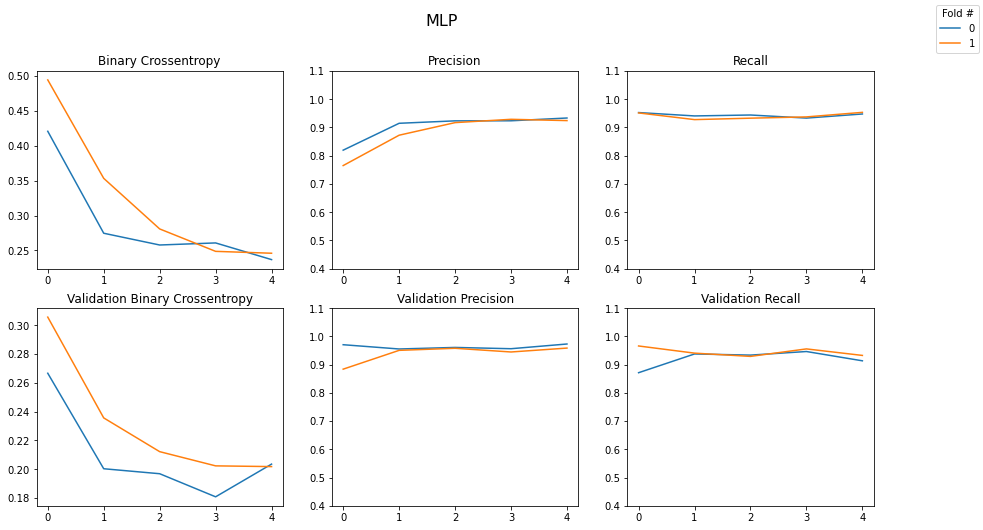

In [22]:
plot_histories(mlp)

### Comparing Models

First, we compare the models based on the f-score of their average validation precision and recall over the 10 folds of cross validation on the training data.

In [98]:
def f_score(model):
    avg_val_precision = np.mean(model['scores'][:,4])
    avg_val_recall    = np.mean(model['scores'][:,5])
    f = 2 * avg_val_precision * avg_val_recall / (avg_val_precision + avg_val_recall)
    return f

f_scores = [[k, f_score(v)] for k, v in models.items()]
f_scores.sort(key=lambda x: -x[1])

print("Model Cross Validation Performance Rankings")
for i, (k, v) in enumerate(f_scores):
    print(f"{i+1}:  F-score: {np.format_float_positional(v, precision=4, trim='k')}  Name: {models[k]['title']}")

Model Cross Validation Performance Rankings
1:  F-score: 0.9438  Name: Basic (Kernel Size: 3)
2:  F-score: 0.9050  Name: NiN (Kernel Size: 5)
3:  F-score: 0.8913  Name: NiN (Kernel Size: 3)
4:  F-score: 0.8861  Name: Basic (Kernel Size: 5)


Now, we use the McNemar test to see if the models are statistically different from one another. Since cross validation does not yield a final trained model, we will be using a single model trained on the entirety of the training set and evaluated on the test set.

In [24]:
from statsmodels.stats.contingency_tables import mcnemar
import copy

def contingency_value(row):
        if row['1'] and row['2']:
            return 'A'
        elif row['1']:
            return 'B'
        elif row['2']:
            return 'C'
        else:
            return 'D'

# arguments are 1D numpy arrays of 0 or 1
def create_contingency_table(truth, model1, model2):
    T  = truth.flatten()
    m1 = model1['results'].flatten()
    m2 = model2['results'].flatten()
    
    # create truth table
    truth_table = pd.DataFrame({'T': T,
                                '1': m1,
                                '2': m2},
                                dtype=bool)
    
    # convert all target values to be 'true' and adjust predictions accordingly
    truth_table.loc[truth_table['T'] == False] = ~truth_table
    
    # get value for each square of the contingency table
    contingency_values = truth_table.apply(contingency_value, axis=1)
    A = len(contingency_values.loc[contingency_values == 'A'])
    B = len(contingency_values.loc[contingency_values == 'B'])
    C = len(contingency_values.loc[contingency_values == 'C'])
    D = len(contingency_values.loc[contingency_values == 'D'])

    return np.array([[A, B],
                     [C, D]])

def get_p_value(truth, model1, model2):
    c_table = create_contingency_table(truth, model1, model2)
    return mcnemar(c_table, exact=False, correction=False).pvalue

def get_better_model(alpha, truth, model1, model2):
    c_table = create_contingency_table(truth, model1, model2)
    
    correct1 = c_table[0,1]
    correct2 = c_table[1,0]
    if correct1 + correct2 == 0:
        p = 1
    else:
        p = get_p_value(truth, model1, model2)
    
    print("Comparing", model1['title'],"to",model2['title'])
    if p >= alpha:
        print(model1['title'], "and", model2['title'], "perform similarly","\n")
        return [model1, model2]
    elif correct1 > correct2:
        print(model1['title'], "performs better than", model2['title'],"\n")
        return [model1]
    else:
        print(model2['title'], "performs better than", model1['title'],"\n")
        return [model2]

In [97]:
alpha = 0.05

similar_to = {}
best_model = list(models.values())[0]
for model in list(models.values())[1:]:
    if best_model['title'] not in similar_to:
        similar_to[best_model['title']] = []
    result = get_better_model(alpha, y_final, best_model, model)
    if len(result) > 1:
        similar_to[best_model['title']].append(model)
    best_model = result[0]
    
    
best_models = [best_model, *similar_to[best_model['title']]]
print("Best Models:")
for model in best_models:
    print(model['title'])

Comparing Basic (Kernel Size: 3) to Basic (Kernel Size: 5)
Basic (Kernel Size: 3) and Basic (Kernel Size: 5) perform similarly 

Comparing Basic (Kernel Size: 3) to NiN (Kernel Size: 3)
Basic (Kernel Size: 3) performs better than NiN (Kernel Size: 3) 

Comparing Basic (Kernel Size: 3) to NiN (Kernel Size: 5)
Basic (Kernel Size: 3) performs better than NiN (Kernel Size: 5) 

Best Models:
Basic (Kernel Size: 3)
Basic (Kernel Size: 5)


In [26]:
# def roc(model):
#     kfold = StratifiedKFold(n_splits=4).split(train_images, train_targets)

#     mean_tpr = 0.0
#     mean_fpr = np.linspace(0, 1, 100)
#     all_tpr = []

#     for i, (train, test) in enumerate(kfold):
#         probas = model.predict(train_images[test])

#         perclass_mean_tpr = 0.0
#         roc_auc = 0
        
#         fpr, tpr, thresholds = roc_curve(train_targets[test],
#                                          probas)
#         perclass_mean_tpr += np.interp(mean_fpr, fpr, tpr)
#         perclass_mean_tpr[0] = 0.0
#         roc_auc += auc(fpr, tpr)

#         mean_tpr += perclass_mean_tpr
#         plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()

In [27]:
# roc(mlp)
# roc(resnet)

### Explanation of McNemar Test Results for Models vs MLP

## Exceptional Work (1 pt)

- You have free reign to provide additional analyses. 
- One idea (<b>required for 7000 level students</b>): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 